# Processing data

In [504]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest

In [505]:
url = r"..\data\raw\clean_house.csv"
house = pd.read_csv(url, sep=",")

## subsetting columns and rows

In [506]:
house.head(5)

,property_id,locality_name,postal_code,latitude,longitude,property_type,property_subtype,price,type_of_sale,number_of_rooms,...,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,swimming_pool,state_of_building,main_city,province
0,11157483,ronse,9600,50.741809,3.607601,HOUSE,HOUSE,245000.0,BUY_REGULAR,NaN,...,1.0,13.0,1.0,161.0,250.0,2.0,0.0,GOOD,ronse,oost-vlaanderen
1,11156843,merelbeke,9820,51.019250,3.760957,HOUSE,HOUSE,315000.0,BUY_REGULAR,NaN,...,1.0,23.0,NaN,NaN,77.0,2.0,NaN,GOOD,merelbeke,oost-vlaanderen
2,11161362,forêt,4870,50.563966,5.675489,HOUSE,HOUSE,325000.0,BUY_REGULAR,NaN,...,1.0,16.0,1.0,420.0,572.0,3.0,NaN,AS_NEW,trooz,luik
3,11153591,ottignies,1340,50.671784,4.575929,HOUSE,HOUSE,395000.0,BUY_REGULAR,NaN,...,1.0,37.0,1.0,76.0,165.0,2.0,NaN,GOOD,ottignies-louvain-la-neuve,waals-brabant
4,11128275,antwerpen merksem,2170,51.243743,4.443372,HOUSE,MIXED_USE_BUILDING,399900.0,BUY_REGULAR,NaN,...,NaN,NaN,NaN,NaN,65.0,2.0,0.0,GOOD,antwerpen,antwerpen


In [507]:
def replace_outliers(df, columns):
    for column in columns:
    # Outliers handling
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        max_value = Q3 + (1.5 * IQR)
        min_value = Q1 - (1.5 * IQR)

        outliers_mask = (df[column] < min_value) | (df[column] > max_value)
        df.loc[outliers_mask, column] = np.nan

        df.dropna(subset=[column], inplace=True)
    return df

In [508]:
lcolm = ["price"]
house = replace_outliers(house,lcolm)

## drop columns

In [509]:
def drop_columns(df, clist):
    ndf = df.drop(columns=clist)
    return ndf


In [510]:
todropcolumns = ["property_id", "locality_name", "latitude", "longitude", "property_type", "type_of_sale", "kitchen_type", "main_city", "postal_code"]
nhouse = drop_columns(house, todropcolumns)

In [511]:

# dropping the NaN values in the columns selected
def droping_null(df, colist):
    df.dropna(subset=colist, inplace=True)
    return df



## transform categorical data to numerical data

In [512]:
def transform_categorical2(df, clist):
    for column in clist:
        # One-hot encode the current column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_ohe = ohe.fit_transform(df[[column]])
        
        # Convert the one-hot encoded features to a DataFrame
        ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
        df = pd.concat([df, ohe_df], axis=1)
        
        # Drop the original categorical column
        df.drop(columns=[column], inplace=True)

    return df

In [513]:
def tranform_label_encoder(df, clist):
    for column in clist:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df



In [514]:
def select_best(df, clistColumns, predict, k):
    sk = SelectKBest(chi2, k=k)
    sk.fit(df[clistColumns], df[predict])
    selected_columns = df.columns[sk.get_support()]
    return df[selected_columns]

    

In [515]:
clist = ["state_of_building", "property_subtype"]
plist = ["province"]
chouse = transform_categorical2(nhouse, plist)
chouse = tranform_label_encoder(chouse, clist)
chouse = droping_null(chouse, "terrace")
chouse = droping_null(chouse, "garden")

## Make the training set and test set

In [516]:
def create_X_y(df, Y):
    X = df.drop(columns=[Y])
    y = df[[Y]]
    return X, y




In [517]:
X, y = create_X_y(chouse, "price")

In [518]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0 )

## Imputation on the X_train, X_test

In [519]:
X_test.shape
X_train.shape 

(2428, 25)

In [520]:
X_train.head(5)

,property_subtype,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,...,province_brussel,province_henegouwen,province_limburg,province_luik,province_luxemburg,province_namen,province_oost-vlaanderen,province_vlaams-brabant,province_waals-brabant,province_west-vlaanderen
2016,6,NaN,176.0,1.0,0.0,0.0,1.0,36.0,1.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3918,6,NaN,365.0,1.0,0.0,0.0,1.0,25.0,1.0,500.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10676,6,NaN,190.0,1.0,NaN,1.0,1.0,50.0,1.0,911.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
425,6,NaN,114.0,1.0,0.0,0.0,1.0,NaN,1.0,200.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
320,6,NaN,185.0,1.0,NaN,0.0,1.0,30.0,1.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [521]:
def replace_NaN_Categorical(df, comlist):
    df[comlist] = df[comlist].fillna(0.0)
    

In [522]:
X_train = drop_columns(X_train, ["number_of_rooms", "furnished"])
X_test = drop_columns(X_test, ["number_of_rooms", "furnished"])

In [523]:
def change_to_int(df, columnsname):
    for column in columnsname:
        df[column] = df[column].round().astype(int)
    return df


In [524]:
def replace_null_median(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].median()
    return df

In [525]:
def replace_null_mean(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].mean()
    return df

In [526]:
def replace_null_to_zero(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = 0
    return df

### replacing values

In [527]:
X_train = replace_null_mean(X_train, ["terrace_area", "garden_area"])
X_train = replace_null_median(X_train, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])

X_test = replace_null_mean(X_test, ["terrace_area", "garden_area"])
X_test = replace_null_median(X_test, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])

In [528]:
X_train = change_to_int(X_train, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])
X_test = change_to_int(X_test, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])

In [529]:
y_test = replace_null_mean(y_test, ["price"])
y_train = replace_null_mean(y_train, ["price"])

In [530]:
columns_with_null = X_train.columns[X_train.isnull().any()].tolist()
X_train = replace_null_to_zero(X_train, columns_with_null)
X_test = replace_null_to_zero(X_test, columns_with_null)

### scaling values

In [531]:
def scaling(df, cl):
    for column in cl:
        scaler = StandardScaler()
        #Fit and transform the data
        df[column] = scaler.fit_transform(df[[column]])
    return df

In [532]:
numerical_columns = ['living_area', 'terrace_area', 'garden_area', 'surface_of_good']
#X_test = scaling(X_test, numerical_columns)
#X_train = scaling(X_train, numerical_columns)

### testing the model

In [533]:
X_train.isnull().sum(), len(X_train)

(property_subtype            0
 living_area                 0
 fully_equipped_kitchen      0
 open_fire                   0
 terrace                     0
 terrace_area                0
 garden                      0
 garden_area                 0
 surface_of_good             0
 number_of_facades           0
 swimming_pool               0
 state_of_building           0
 province_antwerpen          0
 province_brussel            0
 province_henegouwen         0
 province_limburg            0
 province_luik               0
 province_luxemburg          0
 province_namen              0
 province_oost-vlaanderen    0
 province_vlaams-brabant     0
 province_waals-brabant      0
 province_west-vlaanderen    0
 dtype: int64,
 2428)

In [534]:
y_test.isnull().sum()

price    0
dtype: int64

In [535]:
X_train.head()

,property_subtype,living_area,fully_equipped_kitchen,open_fire,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,...,province_brussel,province_henegouwen,province_limburg,province_luik,province_luxemburg,province_namen,province_oost-vlaanderen,province_vlaams-brabant,province_waals-brabant,province_west-vlaanderen
2016,6,176.0,1,0.0,1.0,36.000000,1.0,21.0,150.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3918,6,365.0,1,0.0,1.0,25.000000,1.0,500.0,1044.0,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10676,6,190.0,1,1.0,1.0,50.000000,1.0,911.0,911.0,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
425,6,114.0,1,0.0,1.0,31.511785,1.0,200.0,330.0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
320,6,185.0,1,0.0,1.0,30.000000,1.0,150.0,245.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [536]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [537]:
regressor.fit(X_train, y_train).predict(X_test)


array([[339598.15908189],
       [575193.41535822],
       [424791.33158585],
       [359615.06333205],
       [260090.93974595],
       [430176.77674788],
       [391453.36265173],
       [258187.97417118],
       [617212.78033402],
       [314597.42972363],
       [361575.25387436],
       [265616.74691448],
       [413567.22979965],
       [353494.31035982],
       [477925.08712406],
       [722082.52064168],
       [672583.85713904],
       [459757.9542404 ],
       [349866.80478443],
       [555612.87525179],
       [472655.38171036],
       [571758.23842469],
       [347098.66845911],
       [248746.79817963],
       [403545.33543965],
       [255929.7929523 ],
       [270454.34545585],
       [512626.22366992],
       [474581.24420924],
       [229026.73624347],
       [471127.99029258],
       [580642.7971722 ],
       [609132.40394386],
       [368592.62929141],
       [453420.57537553],
       [373777.98255839],
       [327812.24620114],
       [372537.12266101],
       [3194

In [538]:
regressor.score(X_train, y_train)

0.385997236220721

In [539]:
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)
score

0.3786919882780212

## Plotting the result

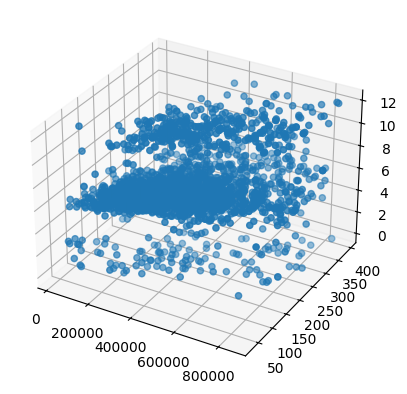

In [540]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train['price'], X_train['living_area'], X_train['property_subtype'])